In [1]:
import os
import math
import random
import warnings
import matplotlib.pyplot as plt
import numpy as np, pandas as pd, polars as pl
from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import MinMaxScaler
from colorama import Fore, Style

import tensorflow as tf, deeptables as dt
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model
#from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from deeptables.models import DeepTable, ModelConfig
from deeptables.models import deepnets


warnings.filterwarnings('ignore')
print('TensorFlow version:',tf.__version__+',',
      'GPU =',tf.test.is_gpu_available())
print('DeepTables version:',dt.__version__)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
TensorFlow version: 2.15.0, GPU = True
DeepTables version: 0.2.6


/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/dask/dataframe/__init__.py:49: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)
/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/sklearn/metrics/_scorer.py:610: FutureWarning: The `needs_threshold` and `needs_proba` parameter are deprecated in version 1.4 and will be removed in 1.6. You can either let `response_method` be `None` or set it to `predict` to preserve the same behaviour.
  warnings.warn(
2024-11-11 11:46:29.437624: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-11-11 11:46:29.437643: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-

In [2]:
seed = 42
def seed_everything(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
seed_everything(seed=seed)

Learning rate schedule: 0.0001 to 0.001 to 0.001


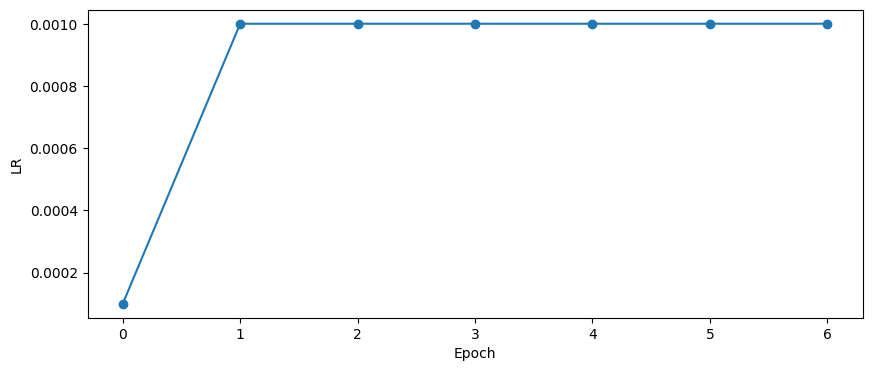

In [3]:
# https://www.kaggle.com/code/cdeotte/tensorflow-transformer-0-790/notebook
LR_START = 1e-4
LR_MAX = 1e-3
LR_MIN = 1e-3
LR_RAMPUP_EPOCHS = 1
LR_SUSTAIN_EPOCHS = 0
EPOCHS = 7

def lrfn(epoch):
    if epoch < LR_RAMPUP_EPOCHS:
        lr = (LR_MAX - LR_START) / LR_RAMPUP_EPOCHS * epoch + LR_START
    elif epoch < LR_RAMPUP_EPOCHS + LR_SUSTAIN_EPOCHS:
        lr = LR_MAX
    else:
        decay_total_epochs = EPOCHS - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS - 1
        decay_epoch_index = epoch - LR_RAMPUP_EPOCHS - LR_SUSTAIN_EPOCHS
        phase = math.pi * decay_epoch_index / decay_total_epochs
        cosine_decay = 0.5 * (1 + math.cos(phase))
        lr = (LR_MAX - LR_MIN) * cosine_decay + LR_MIN    
    return lr

rng = [i for i in range(EPOCHS)]
lr_y = [lrfn(x) for x in rng]
plt.figure(figsize=(10, 4))
plt.plot(rng, lr_y, '-o')
plt.xlabel('Epoch'); plt.ylabel('LR')
print("Learning rate schedule: {:.3g} to {:.3g} to {:.3g}". \
      format(lr_y[0], max(lr_y), lr_y[-1]))
LR_Scheduler = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=True)

In [4]:
class CFG:
    train_path = '../data/raw/train.csv'
    split_agent_features = True
    scaler = MinMaxScaler()  # Scaler or None
    
    nn = True    
    folds = 5
    epochs = 7
    batch_size = 128
    LR_Scheduler = [LR_Scheduler]
    optimizer = Adam(learning_rate=1e-3)
    conf = ModelConfig(
        auto_imputation=False,
        auto_discrete=False,
        auto_discard_unique=True,
        categorical_columns='auto',
        apply_gbm_features=True,
        fixed_embedding_dim=True,
        embeddings_output_dim=4,
        embedding_dropout=0.2,
        nets=['dnn_nets'] + ['fm_nets'] + ['cin_nets'],
        dnn_params={
            'hidden_units': ((1024, 0.0, True),
                             (512, 0.0, True),
                             (256, 0.0, True),
                             (128, 0.0, True)),
            'dnn_activation': 'relu',
        },
        stacking_op='concat',
        output_use_bias=False,
        optimizer=optimizer,
        task='regression',
        loss='auto',
        metrics=["RootMeanSquaredError"],
        earlystopping_patience=1,
    )

In [5]:
constant_cols = pd.read_csv('../data/constant_columns.csv').columns.to_list()
target_col = 'utility_agent1'
game_col = 'GameRulesetName'
game_rule_cols = ['EnglishRules', 'LudRules']
output_cols = ['num_wins_agent1', 'num_draws_agent1', 'num_losses_agent1']
dropped_cols = ['Id'] + constant_cols + game_rule_cols + output_cols
agent_cols = ['agent1', 'agent2']

def preprocess_data(df): 
    df = df.drop(filter(lambda x: x in df.columns, dropped_cols))
    if CFG.split_agent_features:
        for col in agent_cols:
            df = df.with_columns(pl.col(col).str.split(by="-").list.to_struct(fields=lambda idx: f"{col}_{idx}")).unnest(col).drop(f"{col}_0")
    df = df.with_columns([pl.col(col).cast(pl.Categorical) for col in df.columns if col[:6] in agent_cols])            
    df = df.with_columns([pl.col(col).cast(pl.Float32) for col in df.columns if col[:6] not in agent_cols and col != game_col])
    df = df.to_pandas()
    df["utility_agent1_rank"] = (
        df["utility_agent1"].rank(method='dense', ascending=True).astype(int)
    )
    print(f'Data shape: {df.shape}\n')

    cat_cols = df.select_dtypes(include=['category']).columns.tolist()
    non_cat_cols = df.select_dtypes(exclude=['category']).columns.tolist()
    num_cols = [num for num in non_cat_cols if num not in [target_col, game_col, "utility_agent1_rank"]]
    return df, cat_cols, num_cols

In [6]:
from sklearn.model_selection import StratifiedGroupKFold

def train(data, cat_cols, num_cols, scaler):
    group_col = "GameRulesetName"
    y_col = "utility_agent1_rank"
    gkf = StratifiedGroupKFold(n_splits=CFG.folds, random_state=2112, shuffle=True)
    split_list = list(gkf.split(data, groups=data[group_col], y=data[y_col]))

    X = data.drop([target_col, "utility_agent1_rank", game_col], axis=1)
    y = data[target_col]
    oof = np.zeros(len(data))
    nn_models = []
    
    print('nn = '+str(CFG.nn),'\n')
    
    for fi, (train_idx, valid_idx) in enumerate(split_list):
        print("#"*25)
        print(f"### Fold {fi+1}/{CFG.folds} ...")
        print("#"*25)
        
        os.makedirs(f"../data/working/nn_models/fold{fi}", exist_ok=True)

        if CFG.nn == True:
            print('\n',"nn model training.",'\n')
            K.clear_session()
            nn_model = DeepTable(config=CFG.conf)
            nn_model.fit(X.iloc[train_idx], y.iloc[train_idx],
                      validation_data=(X.iloc[valid_idx], y.iloc[valid_idx]),
                      callbacks=CFG.LR_Scheduler,
                      batch_size=CFG.batch_size, epochs=CFG.epochs, verbose=2)
            nn_models.append(nn_model)
            
            # Save model
            # nn_model.save(f'../data/working/nn_models/fold{fi}')
        
            # Avoid some errors
            with K.name_scope(CFG.optimizer.__class__.__name__):
                for j, var in enumerate(CFG.optimizer.weights):
                    name = 'variable{}'.format(j)
                    CFG.optimizer.weights[j] = tf.Variable(var, name=name)
            CFG.conf = CFG.conf._replace(optimizer=CFG.optimizer)

            oof_preds = nn_model.predict(X.iloc[valid_idx], verbose=1, batch_size=512).flatten()
            rmse = np.round(np.sqrt(np.mean((oof_preds - y.iloc[valid_idx])**2)),4)
            print(f'{Fore.GREEN}{Style.BRIGHT}\nFold {fi+1} | rmse: {rmse}\n')
            if fi<CFG.folds: oof[valid_idx] = oof_preds
            else: oof[valid_idx] += oof_preds
        else:
            raise ValueError("Neural network model not enabled in CFG.")
    
    rmse = np.round(np.sqrt(np.mean((oof - y)**2)),4)
    print(f'{Fore.BLUE}{Style.BRIGHT}Overall CV rmse: {rmse}\n')
    plot_model(nn_model.get_model().model)
    return nn_models


def infer(data, nn_models, ctb_models, num_cols, scaler):
    return np.mean(
        [model.predict(data, verbose=1, batch_size=512).flatten()
         for model in nn_models
        ],
        axis=0
    )


In [7]:
scaler = CFG.scaler
train_df = pl.read_csv(CFG.train_path)
train_df, cat_cols, num_cols = preprocess_data(train_df)
if scaler is not None:
    print(f'Scaling {len(num_cols)} numerical cols.\n')
    train_df[num_cols] = scaler.fit_transform(train_df[num_cols])

Data shape: (233234, 599)

Scaling 588 numerical cols.



In [8]:

nn_models = train(train_df, cat_cols, num_cols, scaler)

nn = True 

#########################
### Fold 1/5 ...
#########################

 nn model training. 

11-11 11:46:31 I deeptables.m.deeptable.py 338 - X.Shape=(186410, 596), y.Shape=(186410,), batch_size=128, config=ModelConfig(name='conf-1', nets=['cin_nets', 'dnn_nets', 'fm_nets'], categorical_columns='auto', exclude_columns=[], task='regression', pos_label=None, metrics=['RootMeanSquaredError'], auto_categorize=False, cat_exponent=0.5, cat_remain_numeric=True, auto_encode_label=True, auto_imputation=False, auto_scale=False, auto_discrete=False, auto_discard_unique=True, apply_gbm_features=True, gbm_params={}, gbm_feature_type='embedding', fixed_embedding_dim=True, embeddings_output_dim=4, embeddings_initializer='uniform', embeddings_regularizer=None, embeddings_activity_regularizer=None, dense_dropout=0, embedding_dropout=0.2, stacking_op='concat', output_use_bias=False, apply_class_weight=False, optimizer=<keras.src.optimizers.legacy.adam.Adam object at 0x35118a650>, loss='auto',

11-11 11:46:32 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _ite

11-11 11:46:32 I deeptables.m.preprocessor.py 263 - Preparing features...
11-11 11:46:32 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.25678515434265137s
11-11 11:46:32 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-11 11:46:32 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.10229611396789551s
11-11 11:46:32 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-11 11:46:33 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.059619 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16885
[LightGBM] [Info] Number of data points in the train set: 186410, number of used features: 584
[LightGBM] [Info] Start training from score 0.046962
11-11 11:46:36 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 3.541358

2024-11-11 11:46:37.301471: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-11 11:46:37.301487: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


11-11 11:46:37 I deeptables.u.dataset_generator.py 250 - create dataset generator with _TFDGForPandas, batch_size=128, shuffle=True, drop_remainder=True
11-11 11:46:38 I deeptables.m.deepmodel.py 235 - Building model...
11-11 11:46:38 I deeptables.m.deepmodel.py 291 - >>>>>>>>>>>>>>>>>>>>>> Model Desc <<<<<<<<<<<<<<<<<<<<<<< 
---------------------------------------------------------
inputs:
---------------------------------------------------------
['all_categorical_vars: (108)', 'input_continuous_all: (576)']
---------------------------------------------------------
embeddings:
---------------------------------------------------------
input_dims: [6, 5, 5, 4, 6, 5, 5, 4, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 31, 

2024-11-11 11:46:42.220451: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1456/1456 - 87s - loss: 0.1352 - root_mean_squared_error: 0.3677 - val_loss: 0.2070 - val_root_mean_squared_error: 0.4550 - lr: 1.0000e-04 - 87s/epoch - 60ms/step

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/7
1456/1456 - 78s - loss: 0.0921 - root_mean_squared_error: 0.3035 - val_loss: 0.1982 - val_root_mean_squared_error: 0.4452 - lr: 0.0010 - 78s/epoch - 54ms/step

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/7
1456/1456 - 78s - loss: 0.0721 - root_mean_squared_error: 0.2686 - val_loss: 0.1962 - val_root_mean_squared_error: 0.4430 - lr: 0.0010 - 78s/epoch - 54ms/step

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/7
1456/1456 - 78s - loss: 0.0625 - root_mean_squared_error: 0.2500 - val_loss: 0.2002 - val_root_mean_squared_error: 0.4474 - lr: 0.0010 - 78s/epoch - 54ms/step

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/7
1456/1456 - 79s - loss: 0.0558 - root_mean_squared_error: 0.2363

11-11 11:55:59 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _ite

11-11 11:55:59 I deeptables.m.preprocessor.py 263 - Preparing features...
11-11 11:56:00 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.26376986503601074s
11-11 11:56:00 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-11 11:56:00 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.10049581527709961s
11-11 11:56:00 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-11 11:56:00 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045882 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16903
[LightGBM] [Info] Number of data points in the train set: 185920, number of used features: 586
[LightGBM] [Info] Start training from score 0.055716
11-11 11:56:03 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 3.336329

11-11 12:05:39 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _ite

11-11 12:05:40 I deeptables.m.preprocessor.py 263 - Preparing features...
11-11 12:05:40 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.2560610771179199s
11-11 12:05:40 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-11 12:05:40 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.10245394706726074s
11-11 12:05:40 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-11 12:05:40 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.044420 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16986
[LightGBM] [Info] Number of data points in the train set: 187070, number of used features: 589
[LightGBM] [Info] Start training from score 0.050456
11-11 12:05:43 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 3.3966610

11-11 12:15:41 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _ite

11-11 12:15:41 I deeptables.m.preprocessor.py 263 - Preparing features...
11-11 12:15:41 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.2710230350494385s
11-11 12:15:41 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-11 12:15:42 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.10116386413574219s
11-11 12:15:42 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-11 12:15:42 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045139 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17097
[LightGBM] [Info] Number of data points in the train set: 187456, number of used features: 595
[LightGBM] [Info] Start training from score 0.033179
11-11 12:15:45 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 3.4534299

11-11 12:26:06 W hypernets.t.cache.py 210 - AttributeError: Can't pickle local object 'make_gradient_clipnorm_fn.<locals>.<lambda>'
Traceback (most recent call last):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/cache.py", line 165, in _cache_call
    cache_key = tb.data_hasher()(key_items)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 20, in __call__
    for x in self._iter_data(data):
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 58, in _iter_data
    yield from self._iter_data(v)
  File "/Users/59008/Library/Caches/pypoetry/virtualenvs/mcts-strength-variants-kSTIVMm8-py3.10/lib/python3.10/site-packages/hypernets/tabular/data_hasher.py", line 53, in _ite

11-11 12:26:06 I deeptables.m.preprocessor.py 263 - Preparing features...
11-11 12:26:07 I deeptables.m.preprocessor.py 338 - Preparing features taken 0.31320691108703613s
11-11 12:26:07 I deeptables.m.preprocessor.py 390 - Categorical encoding...
11-11 12:26:07 I deeptables.m.preprocessor.py 395 - Categorical encoding taken 0.10121488571166992s
11-11 12:26:07 I deeptables.m.preprocessor.py 436 - Extracting GBM features...
11-11 12:26:07 I hypernets.t.sklearn_ex.py 640 - LightGBM task:regression
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.045985 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 17043
[LightGBM] [Info] Number of data points in the train set: 186080, number of used features: 592
[LightGBM] [Info] Start training from score 0.035732
11-11 12:26:11 I deeptables.m.preprocessor.py 447 - Extracting gbm features taken 3.795848

***